# Introduction

We have a dataset that contains occurences of a kettle in a
single-occupancy house for the duration of a month.

# Task1 

## Objective:

We need to find routines in the data and evaluate their periodicities and
variabilities.

# Import Modules

In this section we import all the required modules for our analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import repeat
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from datetime import date
from sklearn.ensemble import IsolationForest

# Read Data

In this section we read our data.

In [2]:
data = pd.read_csv('Q4-data.csv',index_col=0)

We check te first 5 rows of our dataframe.

In [3]:
data.head()

,ts,seconds
0,1551685815,275
1,1551686207,14
2,1551686461,21
3,1551697913,170
4,1551698199,12


The column 'ts' indicates the unix timestamp that the kettle was turned on. The unix timestamp is a way to track time as a running total of seconds. This count starts at the Unix Epoch on January 1st, 1970 at UTC. We can convert that into a regular timestamp which shows the date and the time. 

In [4]:
from datetime import datetime
data['timestamp'] = data['ts'].apply(datetime.fromtimestamp)#convert the unix timestamp into a regular timestamp. Put that into a new column with name 'timestamp'.
data.drop('ts',axis=1,inplace=True)#drop the 'ts' column, as we are not going to use that in the following. 
data.head()#check first 5 rows again.

,seconds,timestamp
0,275,2019-03-04 07:50:15
1,14,2019-03-04 07:56:47
2,21,2019-03-04 08:01:01
3,170,2019-03-04 11:11:53
4,12,2019-03-04 11:16:39


Hence, we successfully converted the 'ts' column in a timestamp column.

As we can see from the above dateframe, we now know the times where the kettle was turned on with second presicion. However, the 'timestamp' column consists of elements of type timestamp, which cannot be used for calculations. For this reason, we want to create a new column, consisting of the total seconds throughout a day corresponding to each timestamp. 

For example the first timestamp (first row) has time value 07:50:15 which corresponds to 7x3600 + 50x60 + 15 = 28215 seconds. 

We are going to find the total seconds for all rows by using the function find_tot_sec, which is defined in the following cell. 
Let's briefly explain, how this function works. 

It receives as inputs the timestamp elements from the column 'timestamp'.
We create a datetime.datetime object having the year, month and day information from the timestamp element of the column. We do not specify the time which means that every element of time (hours, minutes, seconds) are set to zero.
We also create another datetime.datetime object, but now we use the year, month, day, hour, minute and second information of the timestamp element. We now can subtract the latter from the former, which gives the respective time difference and then apply the total_seconds() method , which converts the time to seconds. 

In [5]:
def find_tot_sec(x):
    
    my_date = x.date() #get the date information from timestamp element
    my_time = x.time() #get the time information from timestamp element
    
    #create a datetime.datetime object using the date information of the timestamp element only (without the time)
    date_to_datetime = datetime(my_date.year, my_date.month, my_date.day) 
    
    #create a datetime.datetime object using the date and time information of the timestamp element
    date_and_time_to_datetime = datetime(my_date.year, my_date.month, my_date.day, my_time.hour, my_time.minute, my_time.second)
    
    #return the total time in seconds
    return (date_and_time_to_datetime - date_to_datetime).total_seconds()

In [6]:
#apply the function we defined above to the 'timestamp' column and set the result into a new column in our dataframe.
data['time turned on (sec)'] = data['timestamp'].apply(find_tot_sec)
data.head()#check the first 5 rows

,seconds,timestamp,time turned on (sec)
0,275,2019-03-04 07:50:15,28215.0
1,14,2019-03-04 07:56:47,28607.0
2,21,2019-03-04 08:01:01,28861.0
3,170,2019-03-04 11:11:53,40313.0
4,12,2019-03-04 11:16:39,40599.0


Finally, we set the 'timestamp' column as the index of the dataframe.

In [7]:
data.set_index('timestamp',drop=True,inplace=True)
data.head()#check the first 5 rows

,seconds,time turned on (sec)
timestamp,,
2019-03-04 07:50:15,275,28215.0
2019-03-04 07:56:47,14,28607.0
2019-03-04 08:01:01,21,28861.0
2019-03-04 11:11:53,170,40313.0
2019-03-04 11:16:39,12,40599.0


# Data Visualization

In this section we make some figures to gain some insight on our data.

Now tha we have prepared our data in a practical and useful form, we will proceed with our analysis. 
We remind the reader that the objective of this task is to find routines of the data. 
We expect each day to have particular routines, which would have specific periodicities and would happen into a time window. Common examples would be breakfast, lunch, etc. 

In order to observe similar daily routines we are going to examine the data of each day separately. In the following cell, we present a scatter plot for each day, where the x axis shows the times that the kettle was turned on at each day and the y axis shows the duration in seconds that the kettle was on.

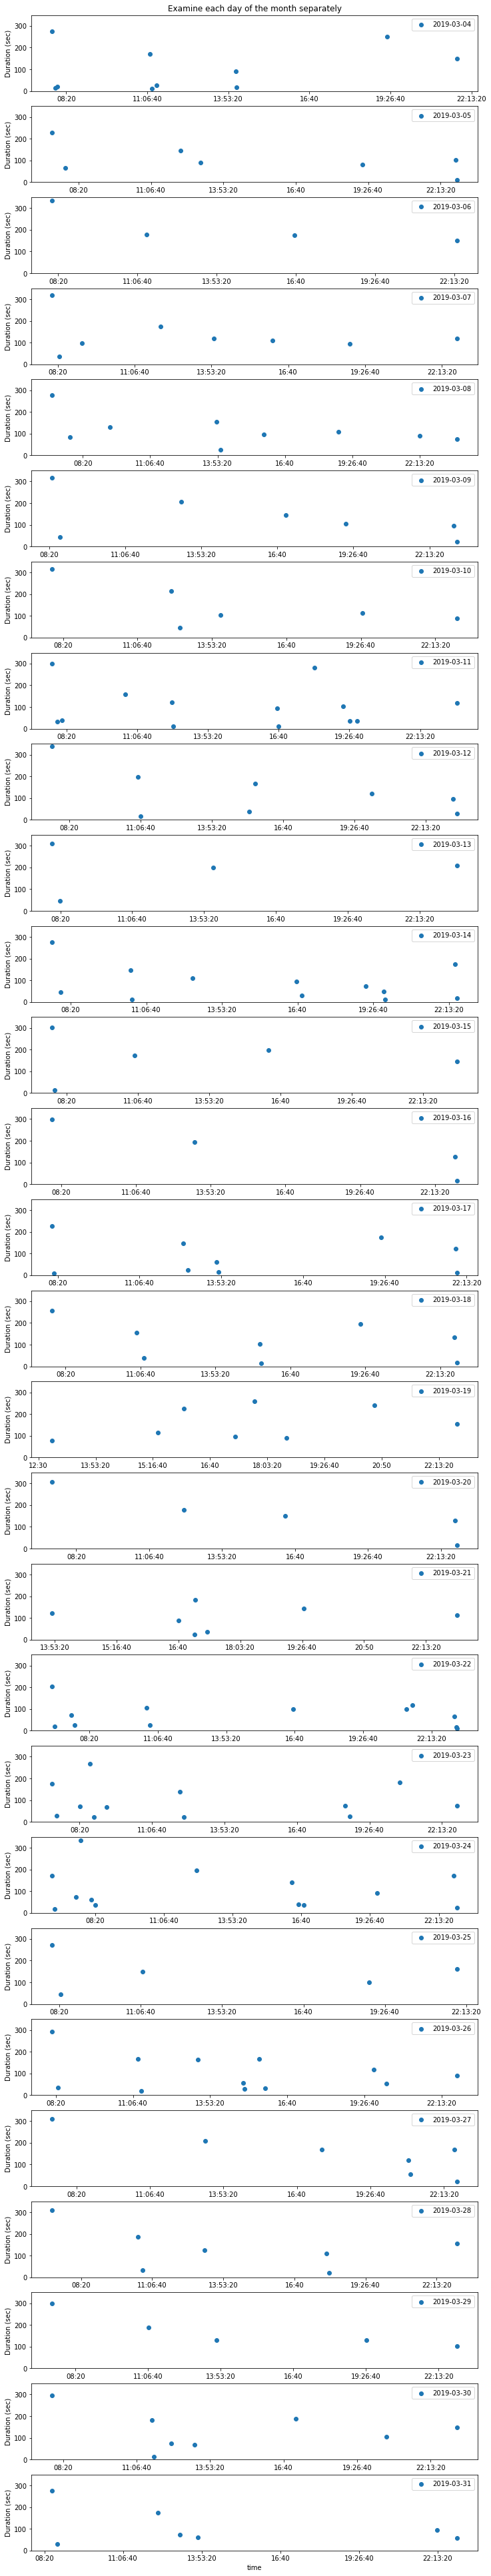

In [8]:
fig, ax = plt.subplots(figsize=(12,70),nrows=28,ncols=1) #create a figure with 28 subplots, one for each day, formed in 28 rows and 1 column.

for i, val in enumerate(data.index.day.unique()):#loop over the 28 unique days of our dataset.
    
    #define a dataframe for each different day for simplicity.
    data_per_day = data[data.index.day == val]
    
    #scatter plot of the time that the kettle was turned on vs the duration that it was on. 
    #We do that for all 28 different days for which we have available data.
    ax[i].scatter(data_per_day.index.time,data_per_day['seconds'])
    
    ax[i].set_ylim(0,350) #set the same limit for the y-axis in order to compare all different subplots in a fair way.
    
    # set the legend of each subplot to be the date of the particular day under consideration
    ax[i].legend((str(data_per_day.index.date[0]),))
        
    #set title for clarification
    ax[0].set_title('Examine each day of the month separately')
    
    #set y label 
    ax[i].set_ylabel('Duration (sec)')
    
    #we delete the x label from all subplots
    ax[i].set_xlabel('')
    
ax[-1].set_xlabel('time'); #we set the xlabel only in the last subplot

We definitely cannot make any analysis using the data of each day, as shown in the above figure, since we have a small number of points in a daily basis. However, this figure is useful because it gives some insight on what kind of daily routines we should expect to see. For example, it is clear that the majority of the days have points in the morning, afternoon, evening and night indicating that we have breakfast, lunch, dinner and the ketle was used at the night as well. We also expect to notice some distinction between points that have small duration and other that last longer. This might indicate that the kettle is used for preparation of beverages or food respectively. 

To summarize, the insights from the above figure is that we should expect different routines (clusters) in the 4 different parts of the day morning, afternoon, evening and night (so the variable here is the time that we turned on the kettle). We should also expect different routines (clusters) depending on the duration (beverages or food or alternatively small amount of water and larger amount of water used in the kettle). 

Now we make another scatter plot, where we plot the same variables across the axes but instead of doing that in a daily basis, we are going to create one figure for each day of the week. For example the first subplot will have all the points from all Mondays, the second will have all the points from all Tuesdays and so on. So, we are going to have seven different subplots, one for each day of the week. This figure will essentially show, if there is any day in the week that something out of the ordinary happens. 

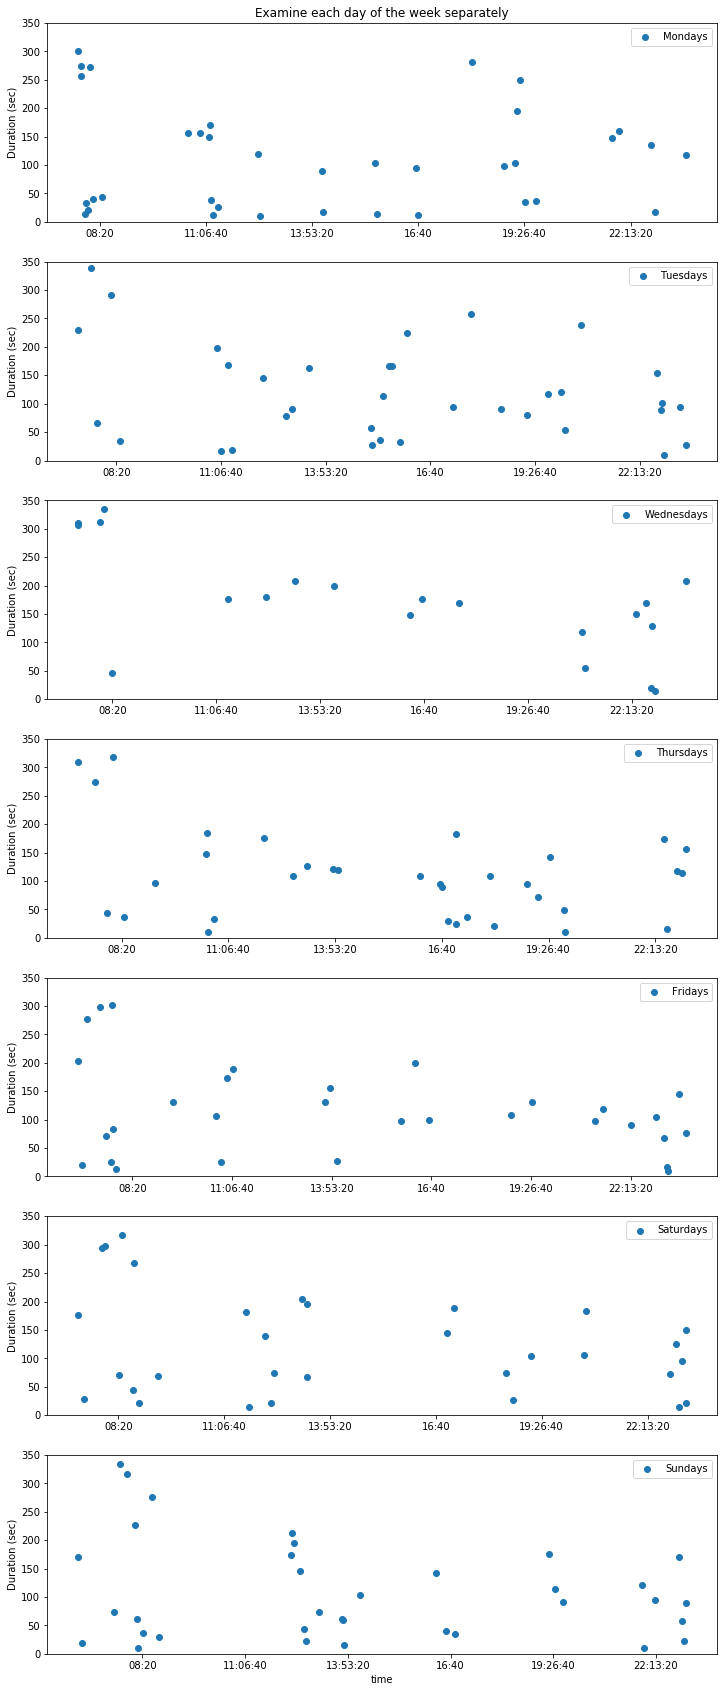

In [9]:
fig, ax = plt.subplots(figsize=(12,30),nrows=7,ncols=1) #create a figure with 7 subplots, formed in 7 rows and 1 column.

for i in range(0,7): 
    
    #define a dataframe containing all the points of each day of the week, e.g. all the points from all Mondays and so on.
    data_per_weekday = data[data.index.dayofweek == i]
    
    #create scatter plot: time of day vs duration in seconds
    ax[i].scatter(data_per_weekday.index.time,data_per_weekday['seconds'])
    
    ax[i].set_ylim(0,350) #set the same limit for the y-axis in order to compare all different subplots in a fair way.

        
    #set legend using the name of the week day under consideration
    ax[i].legend(( (data_per_weekday.index.day_name()[0] + 's'),))
    
    #set title for clarification
    ax[0].set_title('Examine each day of the week separately')
    
    #set the y label of each subplot 
    ax[i].set_ylabel('Duration (sec)')
    
    #we delete the x label from all subplots
    ax[i].set_xlabel('')
    
ax[-1].set_xlabel('time'); #we set the xlabel only in the last subplot

From the above figure, again we notice similar patterns with what we observed in the daily subplots. Hence, we have group of points occuring in the morning (indicating breakfast), early in the afternoon (indicating lunch), late in the afternoon or early in the evening (indicating dinner) and late in the evening. Also, we have group of points with small and large durations occuring at all these time zones distinguishing them between small amount of water (e.g. beverages) and larger amount of water (e.g. food). 
In general, we also notice that we have similar behavior amongst all days of the week. The only special point we noticed is that on Wednesdays, between 11:00 and 19:00 we do not have any points with duration smaller than 150 seconds (indicating afternoon beverages), as we have in all the other days.

Furthermore, we create another figure consisting of 4 subplots, where each one of them contains the data points of each week of the month under consideration. The x and y axis represent the same quantities as before. This figure would help us realise if anything special happens during a particular week of the month. 

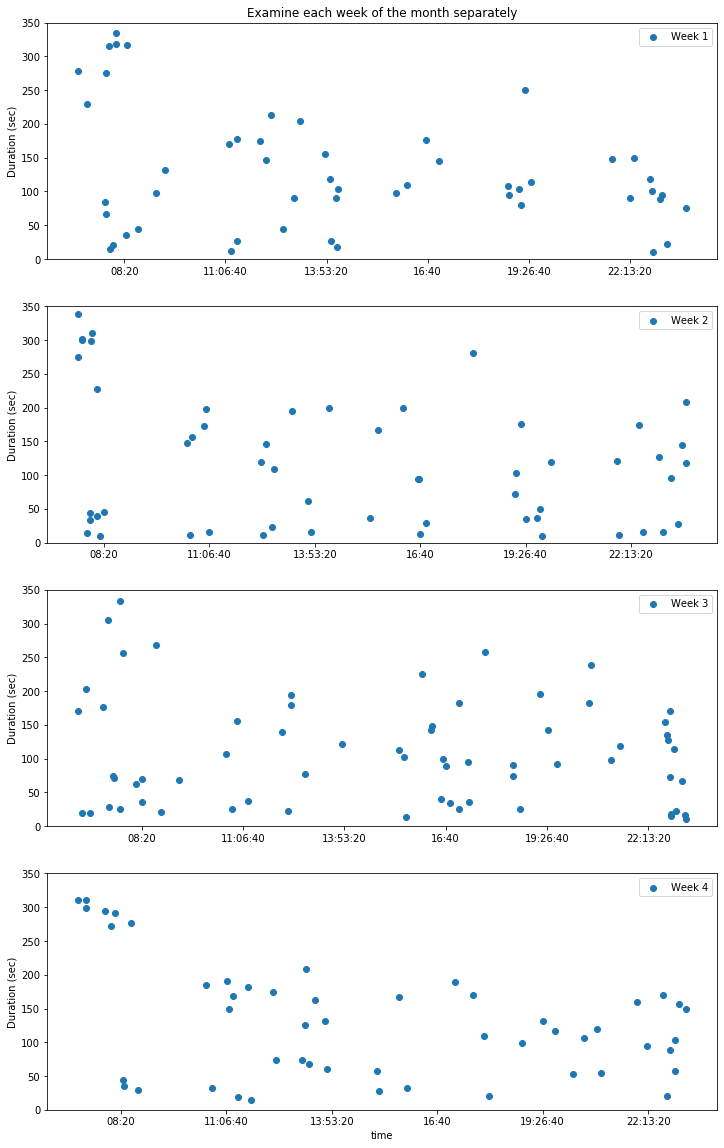

In [10]:
fig, ax = plt.subplots(figsize=(12,20),nrows=4,ncols=1) #create a figure with 7 subplots, formed in 7 rows and 1 column.
for i,val in enumerate(data.index.week.unique()): #loop over each different week of the month
    
    data_per_week = data[data.index.week == val] #create a dataframe for each different week of the month
    
    #create scatter plot: time of day vs duration in seconds
    ax[i].scatter(data_per_week.index.time,data_per_week['seconds'])
    
    
    ax[i].set_ylim(0,350) #set the same limit for the y-axis in order to compare all different subplots in a fair way.

    
    #set the legend of each subplot as the number of week of the month
    ax[i].legend(( ('Week' + ' ' + str(i + 1)) ,))
    
    #set title for clarification
    ax[0].set_title('Examine each week of the month separately')
    
    #set the y label of each subplot 
    ax[i].set_ylabel('Duration (sec)')
    
    #we delete the x label from all subplots
    ax[i].set_xlabel('')
    
ax[-1].set_xlabel('time'); #we set the xlabel only in the last subplot

From the above figure, we notice that in all four weeeks we have similar behaviour, so nothing really special happens during a specific week. Again, we notice the same patterns with the two previous figures. Here, we have more points, supporting our initial insight about the available routines and patterns.

Finally, we create a scatterplot containing all the available points during the month.

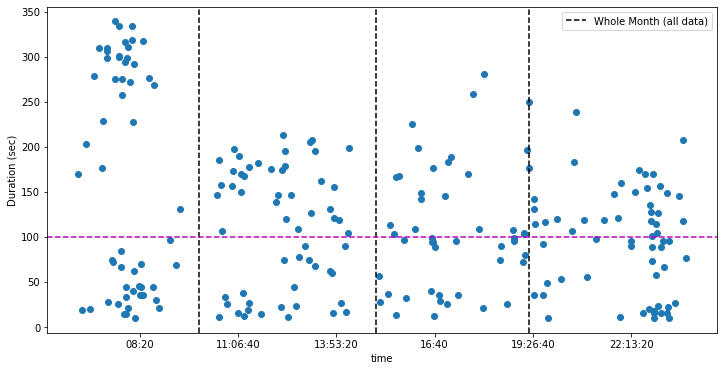

In [11]:
import datetime
figure, ax = plt.subplots(figsize=(12,6)) #create figure and adust its size for clarity
ax.scatter(data.index.time,data['seconds'])#scatter plot of the time vs duration

#we plot some vertical and horizontal lines to split the day into different time zones and durations
plt.axvline(x=datetime.time(10,0,0),color='k',ls='--') 
plt.axvline(x=datetime.time(15,0,0),color='k',ls='--')
plt.axvline(x=datetime.time(19,20,0),color='k',ls='--')
plt.axhline(y=100,color='m',ls='--')
ax.set_ylabel('Duration (sec)'); #set y-label
ax.legend(('Whole Month (all data)',)); #set legend

The above figure, has the behaviour we analysed earlier, as expected. The only problem is that the points are quite expanded, namely they do not clearly form highly concentrated clusters. This would affect our decision about how many clusters we should consider. The black dashed vertical lines split the x-axis in the different time zones as explained earlier, while the dashed magenta horizontal line splits the points in two different groups with respect to the y-axis. We will analyze that a bit further in the following section as well.

# Clustering

We aim to use an unsupervised machine learning method in order to clusterize our data points into different groups. We are going to use the KMeans clustering algorithm.

## Strategy:

Since we aim to use an unsupervised learning method we do not know the labels of our data or even how many different labels we have. That means that we should choose the number of different clusters we are going to use in our algorithm. 

Based on our previous analysis, we should have 4 different time zones, 1) morning, 2) ealry afternoon, 3) late afternoon and early evening and lastly 4) late evening (represented by the three dashed black vertical lines in the previous figure). This was a separation into groups with respect to the x-axis. Also, we can notice from the figure above, that we essentially have 2 main different behaviours with respect to the y-axis. Namely we see that there are slightly two separated groups of points, where the threshold line in the y-axis is around 100 seconds (magenta dashed horizontal line). As we explained earlier, this separation with respect to the y-axis, might denote the different amount of water we use in the kettle, which might represent that the kettle is used for beverages or for food. 

To conclude, given the data points shown in the figure above and the common experience with how and when we mainly use kettles, we believe that the appropriate number of clusters we should use is (4 different time zones) x (2 different uses in each time zone) = 8 total number of clusters. 

We are also going to use the elbow method, in order to check if 8 different clusters would be one of the optimal number of clusters we should use in our problem. 

In order to do so, we firstly need to define the features of our problem, which are going to be used to fit the KMeans algorithm. We will use two features, the first one will be the duration in seconds that the kettle was on, and the second one will be the time, expressed in total seconds during the day, that the kettle was turned on.

In [12]:
#define the features using the values of the two columns of our dataframe
X = data[['seconds','time turned on (sec)']].values 

In [13]:
data.head()

,seconds,time turned on (sec)
timestamp,,
2019-03-04 07:50:15,275,28215.0
2019-03-04 07:56:47,14,28607.0
2019-03-04 08:01:01,21,28861.0
2019-03-04 11:11:53,170,40313.0
2019-03-04 11:16:39,12,40599.0


From the above dataframe we notice that the values of the two columns we use as our features have different orders of magniture, i.e. the values of the column 'time turned on (sec)' are much larger than the values of the columns 'seconds'. 
If we use those values as they are, our algorithm is going essentially to clusterize the points considering only the feature with the larger values. For this reason, we firstly need to standardize our data in order to have similar scales. We are going to use MinMaxScaler for that purpose.

In [14]:
scaler = MinMaxScaler() #instantiate a MinMaxScaler object
scaler.fit(X) #fit our scaler with the values of our features
X_scaled = scaler.transform(X) #transform the values of our features in order to have zero mean and standard deviation one. 

## Elbow Method

We are going to use the scaled values of our features into the algorithm.

In [15]:
sum_of_squared_distances = [] #create an empty list
max_number_clusters = 15 #define max number of clusters we are going to consider
for i in range(1,max_number_clusters): # loop over the different numbers of clusters
    kmeans = KMeans(i) #for each different number of clusters create a KMeans object
    kmeans.fit(X_scaled)#fit the model with the scaled feature values
    sum_of_squared_distances.append(kmeans.inertia_) #find the sum of squared distances for each different number of clusters and add them to the corresponding list 

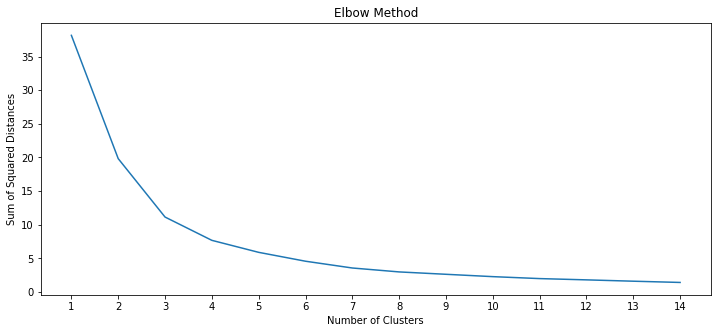

In [16]:
number_of_clusters = np.arange(1,max_number_clusters) #define a vector containing the different number of clusters we examined
plt.figure(figsize=(12,5)) #create a figure and adjust its size
plt.plot(number_of_clusters,sum_of_squared_distances) #plot the different number of cluster vs the sum of squared distances 
plt.xticks(ticks=number_of_clusters) #set xticks
plt.xlabel('Number of Clusters')#set xlabel
plt.ylabel('Sum of Squared Distances')#set ylabel
plt.title('Elbow Method');#set title

From the figure above we notice that 8 is one of the optimal values for the number of clusters we should use in our KMeans algorithm.

## KMeans Clustering Algorithm

In this section, we are going to use the KMeans algorithm to separate our data points into different clusters. More particularly, as analysed in the previous section we are going to use 8 different number of clusters. In addition, using the insight from the figures examined earlier, we are going to set the initial position of the centroids in the KMeans algorithm.
As pointed out earlier, we are going to use the scaled values of our features in order to fit the algorithm.

In [17]:
#define initial position of centroids for the 8 different clusters
init_centers = np.array([[10,8*3600],[50,8*3600],[10,10*3600],[50,12*3600],
                    [10,13*3600],[50,18*3600],[10,22*3600],[50,22*3600]]) 

#scale the positions of the initial centroids we have just defined, using the same scaler as before.
init_centers_scaled = scaler.transform(init_centers)

#Instantiate an object of the KMeans algorithm, using 8 different clusters, the initial position of the centroids we have just
#defined and we also set a fixed value for the random_state in order to get the same result every time we run our code.
kmeans = KMeans(8, init = init_centers_scaled, random_state=42)

#fit the algorithm using the scaled values of the features.
kmeans.fit(X_scaled)

#make predictions: to which cluster each point belong.
clusters = kmeans.predict(X_scaled)

C:\Users\mk567\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


We make the same scatter plot using all our data points as before, but now we use a different color to denote the different clusters we have.

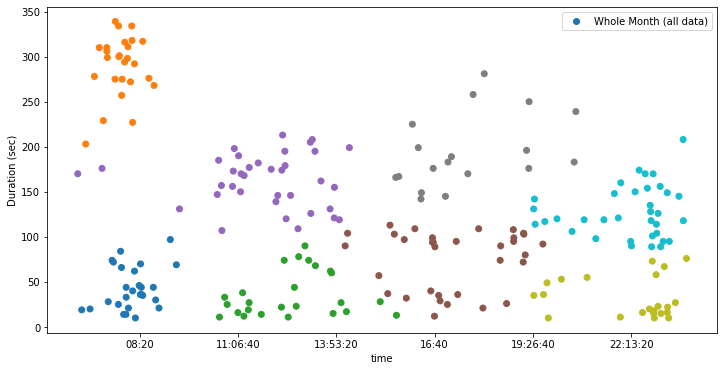

In [18]:
figure, ax = plt.subplots(figsize=(12,6))#create figure and appropriately adjust its size

#scatter plot: time vs duration, where we use a different color for each cluster. We also determint a specific color map 
#in order each clusters color to be clearly distinguished from the others.
ax.scatter(data.index.time,data['seconds'],c=clusters,cmap='tab10')
ax.set_ylabel('Duration (sec)'); #set y label
ax.legend(('Whole Month (all data)',)); #set legend

From the above figure, we notice that all the points are clusterized in 8 different groups. First of all, we can see the distinction with respect to the x-axis in 4 different time zones, morning, early afternoon, late afternoon + early evening and late evening. We also notice that each time zone has two differenrt groups depending on the value of the duration (y-axis), exactly as explained earlier. This agreement with our previous analysis is not such a suprice, since we chose the number of clusters and the centroid initial positions, based on this analysis. However, the fact that the algorithm gives results supporting this whole analysis is something promising. 

In the morning we, we have two different clusters, both happening at around 8:00a.m. The first one with orange color, has significantly larger duration than the second one (blue). This might indicate that the orange cluster is referred to making breakfast food, while the blue cluster refers the breakfast beverages. 

Moving a bit further we notice that we have two different clusters (with purple and green colors) from around 10:00a.m. to 14:00a.m. Again the green cluster which has smaller durations might refer to beverages around lunch, while the purple one probably refers to cooking lunch. 

Then we have two more clusters (grey and brown). Following the same logic as earlier, the brown one should refer to beverages before dinner (late afternoon) and the grey one is probably referring to cooking dinner. 

Finally, after dinner (late evening) we have two more clusters (gold and light blue). Since we would not commonly expect any other meal at this time, we assume that the cluster with larger durations, maybe refers to cases where we have guests and consequently we would make more beverages than usual, or maybe we use hot water from the kettle in order to clean something. The main point is that the cluster with the light blue color indicates cosiderably larger amount of hot water. Again the cluster with the smaller values refer to smaller amount of water, so probably just a couple of beverages. 

We add a column in our dataframe which denotes to which cluster each instance belongs. 

In [19]:
data['Clusters'] = clusters

We define different dataframes for each cluster. This is going to be useful later.

In [20]:
break_bev_df = data[data['Clusters'] == 0] # refers to beverages at breakfast
break_food_df = data[data['Clusters'] == 1] # refers to food at breakfast

early_afternoon_bev_df = data[data['Clusters'] == 2] # refers to beverages around lunch
early_afternoon_food_df = data[data['Clusters'] == 3] #refers to lunch

late_afternoon_bev_df = data[data['Clusters'] == 4] # refers to beverages around dinner
late_afternoon_food_df = data[data['Clusters'] == 5] #refers to dinner

late_evening_bev_small_df = data[data['Clusters'] == 6] # refers to small beverages after dinner
late_evening_bev_large_df = data[data['Clusters'] == 7] # refers to large beverages after dinner

## Routines: Times and Variabilities

In this section, we are going to find the median times and time windows of our routines. We should remind the reader here that in the way we have clusterized our points, we expect that the clusters created with respect to the y-axis (duration that the kettle was on) would have similar time median values and variabilities, since they occur at the same time zone. We find the median values, instead of the mean values, because as we are going to see in the following figures, the distribution of our routines in some cases are skewed.

We start with the first routine, which refers to the beverages at breakfast. We find the median value and the standard deviation of these points. We also create a plot of the distribution of the times of the breakfast beverages routine. 

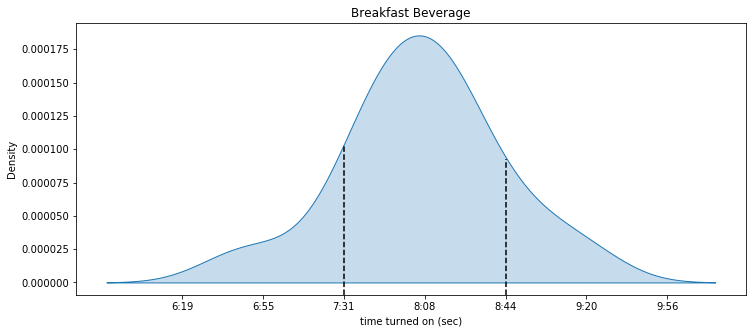

In [21]:
median_value = break_bev_df['time turned on (sec)'].median() #median value
sigma = break_bev_df['time turned on (sec)'].std() #standard deviation

low_window = median_value - sigma 
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - 3*sigma), (median_value - 2*sigma), (median_value - sigma), median_value, (median_value + sigma), (median_value + 2*sigma), (median_value + 3*sigma)])
x_ticks_labels = []

for val in x_ticks_values:
    #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
    x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:4]) 

fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(break_bev_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in order to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.55)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.50)
plt.title('Breakfast Beverage');#set title of figure for clarity.


In this figure we notice that the time window of this routine, which is identified by the vertical black dashed lines is from 7:31 to 8:44 and the value in the middle, 8:08, is the median value of the routine. We also print the exact median value and time window of this routine in the following cell. 

In [22]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of breakfast beverages is: {}.'.format(median_value[:7]))  
print('The time window of brekfast beverage is from {} to {}.'.format(low_window_time[:7],up_window_time[:7]))

The median time of breakfast beverages is: 8:08:09.
The time window of brekfast beverage is from 7:31:54 to 8:44:23.


The next routine is preparing the food at breakfast. We follow the same process to find the median value and variabilities of this routine as well. 

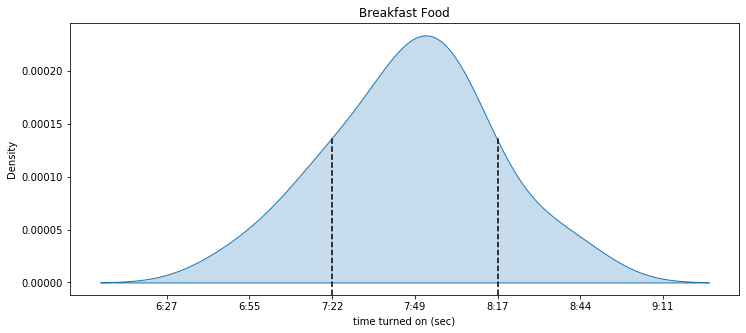

In [23]:
median_value = break_food_df['time turned on (sec)'].median()
sigma = break_food_df['time turned on (sec)'].std()
low_window = median_value - sigma
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - 3*sigma), (median_value - 2*sigma), (median_value - sigma), median_value, (median_value + sigma), (median_value + 2*sigma), (median_value + 3*sigma)])
x_ticks_labels = []

for val in x_ticks_values:
    #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
    x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:4]) 

fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(break_food_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in order to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.58)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.58)
plt.title('Breakfast Food');#set title of figure for clarity.

In [24]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of breakfast food is: {}.'.format(median_value[:7]))  
print('The time window of brekfast food is from {} to {}.'.format(low_window_time[:7],up_window_time[:7]))

The median time of breakfast food is: 7:49:51.
The time window of brekfast food is from 7:22:31 to 8:17:11.


The next routine refers to beverages early in the afternnoon (around lunch). We follow the same process to find the median value and variabilities of this routine as well. 

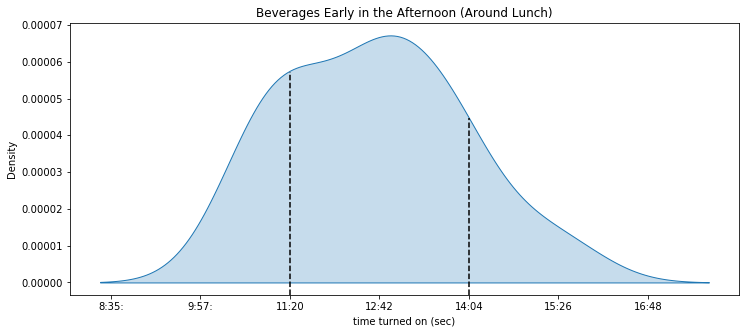

In [25]:
median_value = early_afternoon_bev_df['time turned on (sec)'].median()
sigma = early_afternoon_bev_df['time turned on (sec)'].std()
low_window = median_value - sigma
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - 3*sigma), (median_value - 2*sigma), (median_value - sigma), median_value, (median_value + sigma), (median_value + 2*sigma), (median_value + 3*sigma)])
x_ticks_labels = []

for val in x_ticks_values:
    #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
    x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:5]) 

fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(early_afternoon_bev_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in order to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.82)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.65)
plt.title('Beverages Early in the Afternoon (Around Lunch)');#set title of figure for clarity.

In [26]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of beverages around lunch is: {}.'.format(median_value[:8]))  
print('The time window of beverages around lunch is from {} to {}.'.format(low_window_time[:8],up_window_time[:8]))

The median time of beverages around lunch is: 12:42:11.
The time window of beverages around lunch is from 11:20:02 to 14:04:19.


The next routine refers to lunch. We follow the same process to find the median value and variabilities of this routine as well. 

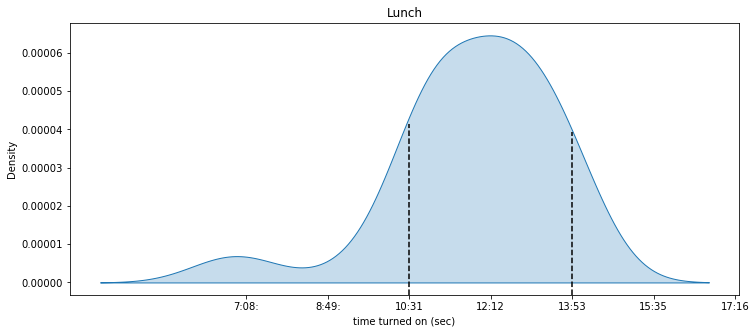

In [27]:
median_value = early_afternoon_food_df['time turned on (sec)'].median()
sigma = early_afternoon_food_df['time turned on (sec)'].std()
low_window = median_value - sigma
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - 3*sigma), (median_value - 2*sigma), (median_value - sigma), median_value, (median_value + sigma), (median_value + 2*sigma), (median_value + 3*sigma)])
x_ticks_labels = []

for val in x_ticks_values:
    #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
    x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:5]) 

fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(early_afternoon_food_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in orde6 to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.63)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.6)
plt.title('Lunch');#set title of figure for clarity.

In [28]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of lunch is: {}.'.format(median_value[:8]))  
print('The time window of lunch is from {} to {}.'.format(low_window_time[:8],up_window_time[:8]))

The median time of lunch is: 12:12:27.
The time window of lunch is from 10:31:09 to 13:53:45.


The next routine refers to beverages late in the afternoon (around dinner). We follow the same process to find the median value and variabilities of this routine as well. 

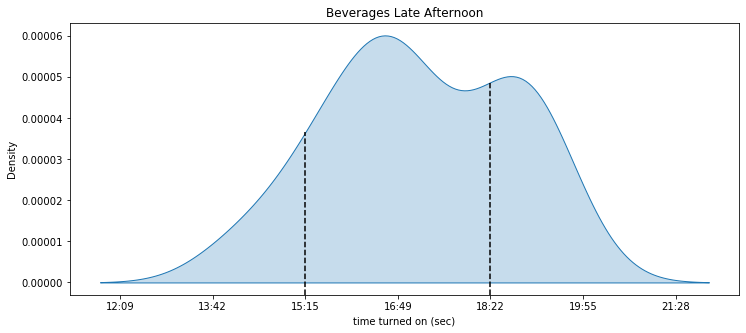

In [29]:
median_value =  late_afternoon_bev_df['time turned on (sec)'].median()
sigma = late_afternoon_bev_df['time turned on (sec)'].std()
low_window = median_value - sigma
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - 3*sigma), (median_value - 2*sigma), (median_value - sigma), median_value, (median_value + sigma), (median_value + 2*sigma), (median_value + 3*sigma)])
x_ticks_labels = []

for val in x_ticks_values:
    #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
    x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:5]) 

fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(late_afternoon_bev_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in order to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.6)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.78)
plt.title('Beverages Late Afternoon');#set title of figure for clarity.

In [30]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of beverages late in the afternoon is: {}.'.format(median_value[:8]))  
print('The time window of beverages late in the afternoon is from {} to {}.'.format(low_window_time[:8],up_window_time[:8]))

The median time of beverages late in the afternoon is: 16:49:03.
The time window of beverages late in the afternoon is from 15:15:47 to 18:22:18.


The next routine refers to dinner. We follow the same process to find the median value and variabilities of this routine as well. 

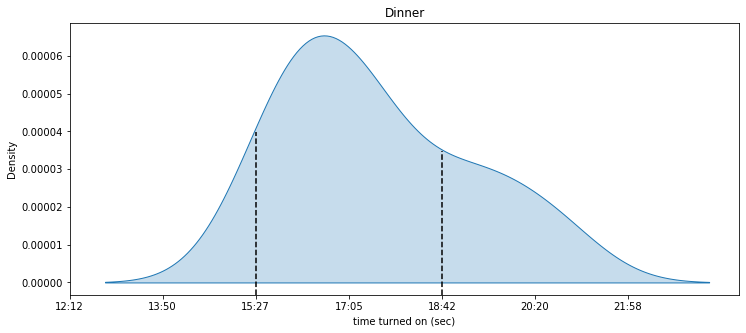

In [31]:
median_value =  late_afternoon_food_df['time turned on (sec)'].median()
sigma = late_afternoon_food_df['time turned on (sec)'].std()
low_window = median_value - sigma
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - 3*sigma), (median_value - 2*sigma), (median_value - sigma), median_value, (median_value + sigma), (median_value + 2*sigma), (median_value + 3*sigma)])
x_ticks_labels = []

for val in x_ticks_values:
    #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
    x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:5]) 

fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(late_afternoon_food_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in order to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.6)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.53)
plt.title('Dinner');#set title of figure for clarity.

In [32]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of dinner is: {}.'.format(median_value[:8]))  
print('The time window of dinner is from {} to {}.'.format(low_window_time[:8],up_window_time[:8]))

The median time of dinner is: 17:05:24.
The time window of dinner is from 15:27:49 to 18:42:58.


The next routine refers to small amount of beverages late in the evening. We follow the same process to find the median value and variabilities of this routine as well. 

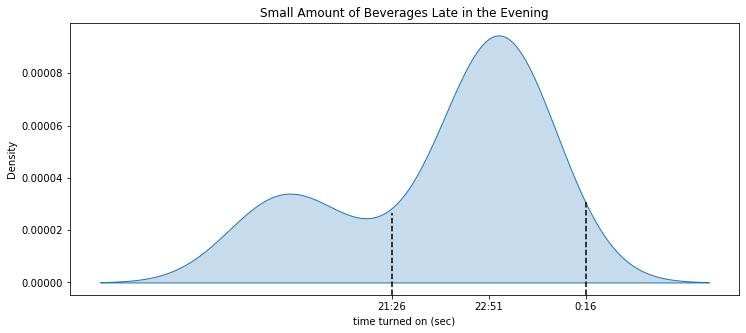

In [33]:
median_value =   late_evening_bev_small_df['time turned on (sec)'].median()
sigma = late_evening_bev_small_df['time turned on (sec)'].std()
low_window = median_value - sigma
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - sigma), median_value, (median_value + sigma)])
x_ticks_labels = []

for i, val in enumerate(x_ticks_values):

    if i == 2 :
        #we change the number of characters we store for the last x tick value because 
        #we move to the next day
        x_ticks_labels.append(str(datetime.timedelta(seconds=val))[7:11]) 
    else:
        #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
        x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:5]) 


fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(late_evening_bev_small_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in order to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.3)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.35)
plt.title('Small Amount of Beverages Late in the Evening');#set title of figure for clarity.

In [34]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of small amount of beverages late in the evening is: {}.'.format(median_value[:8]))  
print('The time window of small amount of beverages late in the evening is from {} to {}.'.format(low_window_time[:8],up_window_time[7:14]))

The median time of small amount of beverages late in the evening is: 22:51:10.
The time window of small amount of beverages late in the evening is from 21:26:10 to 0:16:09.


The next routine refers to large amount of beverages late in the evening. We follow the same process to find the median value and variabilities of this routine as well. 

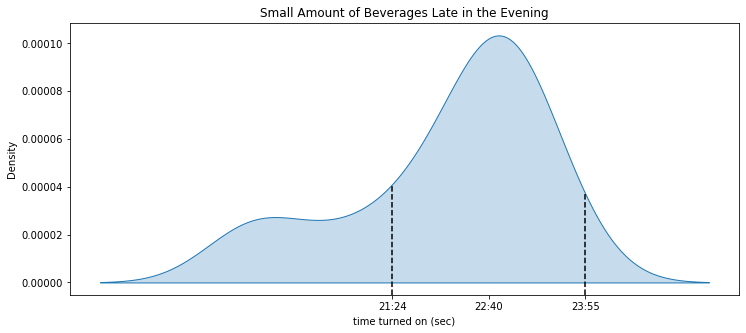

In [35]:
median_value = late_evening_bev_large_df['time turned on (sec)'].median()
sigma = late_evening_bev_large_df['time turned on (sec)'].std()
low_window = median_value - sigma
up_window = median_value + sigma

#we create a list of the xtick values and labels that we are going to use in the following figure. 
#We use the median value (m) and the standard deviation sigma to store the values
# [m-3*sigma, m-2*sigma, m-sigma, m ,m+sigma, m + 2*sigma, m+3*sigma] in a list
#we also store in another list the corresponding labels as strings in time format.
x_ticks_values = np.array([(median_value - sigma), median_value, (median_value + sigma)])
x_ticks_labels = []

for val in x_ticks_values:
    #we store the time labels with only minute precision, in order not to have a very crowded x-axis.
    x_ticks_labels.append(str(datetime.timedelta(seconds=val))[:5]) 

fig, ax = plt.subplots(figsize=(12,5)) #create figure
sns.kdeplot(late_evening_bev_large_df['time turned on (sec)'],shade=True) #plot distribution of times of this routine
plt.xticks(ticks=x_ticks_values,labels=x_ticks_labels)#use the xticks values and labels we found
#plot vertical lines at m-sigma and m+sigma in order to identify the time window of the routine.
plt.axvline(x= low_window,color='k',ls='--',ymax=0.4)
plt.axvline(x= up_window,color='k',ls='--',ymax=0.38)
plt.title('Small Amount of Beverages Late in the Evening');#set title of figure for clarity.

In [36]:
#we firstly need to convert the total seconds in a time form.
median_value = str(datetime.timedelta(seconds=median_value))
sigma_time = str(datetime.timedelta(seconds=sigma))
low_window_time = str(datetime.timedelta(seconds=low_window))
up_window_time  = str(datetime.timedelta(seconds=up_window))

#we print the time up to second precision. This is why we go up to the 7th element of the strings.
print('The median time of small amount of beverages late in the evening is: {}.'.format(median_value[:8]))  
print('The time window of small amount of beverages late in the evening is from {} to {}.'.format(low_window_time[:8],up_window_time[:8]))

The median time of small amount of beverages late in the evening is: 22:40:17.
The time window of small amount of beverages late in the evening is from 21:24:55 to 23:55:38.


In this section we found the median times and time windows that each routine happens. From all these figures, we presented in this section, we noticed that the distributions of most of the routines have rather long tails, and in some cases they also present more than one picks. This evidently shows that the points in each cluster are not so much concetraded with each other. In other words, we have outliers in each cluster. In the following section we are going present a method in order to identify such anomalies.

# Task 2

## Objective:

In this section we aim to detect anomalies, whenever there is a deviation from the routines.

As we mentioned in the previous section, the points in each cluster are not too much concetrated with each other. For that reason, it would not be useful to apply an outlier detection algorithm in all the data points at once. In that case, the most probable scenario would be that the algorithm would not be able to clearly identify the clusters and their outliers, resulting in identifying most of the points as outliers. This is the reason why, we are going to apply an outlier detection algorithm for each cluster separately. 

## Isolation Forest

We are going to use the isolation forest algorithm to detect the anomalies in our dataset.

As we mentioned we are going to apply our anomaly detection algorithm in each cluster seperately and we will follow the same steps for each case. Here we present a roadmap of the steps we are going to follow in the next cell:

1) Define the features for each different cluster.

2) Define a scaler for each different cluster and standardize the values of the features.

3) Instantiate the Isolation Forest algorithm for each different cluster.

4) Fit our model using the scaled values of the features of each cluster.

5) Make predictions using the scaled values of features, which essentially will determine the inliers and the outliers of each cluster.

6) Create a corresponding column in the dataframe of each routine having the values +1 for inlier instances and -1 for outlier instances.

In [37]:
number_estimators = 5 #we are going to use 5 trees in our random forest
random_seed = 42 #we specify this parameter to obtain same results every time we run our code. 

#.......................................Breakfast Beverage Isolation Forest...............................

X_break_bev = break_bev_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_break_bev = MinMaxScaler() #define scaler for these features
X_break_bev_scaled = scaler_break_bev.fit_transform(X_break_bev) # fit and transform feature values

iso_for_break_bev = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_break_bev.fit(X_break_bev_scaled) #fit our model using scaled features
outliers_break_bev = iso_for_break_bev.predict(X_break_bev_scaled) # make predicitons using scaled features
break_bev_df['Outliers'] = outliers_break_bev #create a column in the dataframe of this cluster containing the inliers and the outliers

#.......................................Breakfast Food Isolation Forest...............................

X_break_food = break_food_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_break_food = MinMaxScaler() #define scaler for these features
X_break_food_scaled = scaler_break_food.fit_transform(X_break_food) # fit and transform feature values

iso_for_break_food = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_break_food.fit(X_break_food_scaled) #fit our model using scaled features
outliers_break_food = iso_for_break_food.predict(X_break_food_scaled) # make predicitons using scaled features
break_food_df['Outliers'] = outliers_break_food #create a column in the dataframe of this cluster containing the inliers and the outliers

#.......................................Early Afternoon Beverage Isolation Forest...............................

X_early_afternoon_bev = early_afternoon_bev_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_early_afternoon_bev = MinMaxScaler() #define scaler for these features
X_early_afternoon_bev_scaled = scaler_early_afternoon_bev.fit_transform(X_early_afternoon_bev) # fit and transform feature values

iso_for_early_afternoon_bev = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_early_afternoon_bev.fit(X_early_afternoon_bev_scaled) #fit our model using scaled features
outliers_early_afternoon_bev = iso_for_early_afternoon_bev.predict(X_early_afternoon_bev_scaled) # make predicitons using scaled features
early_afternoon_bev_df['Outliers'] = outliers_early_afternoon_bev #create a column in the dataframe of this cluster containing the inliers and the outliers


#..............................................Lunch Isolation Forest...............................

X_early_afternoon_food = early_afternoon_food_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_early_afternoon_food = MinMaxScaler() #define scaler for these features
X_early_afternoon_food_scaled = scaler_early_afternoon_food.fit_transform(X_early_afternoon_food) # fit and transform feature values

iso_for_early_afternoon_food = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_early_afternoon_food.fit(X_early_afternoon_food_scaled) #fit our model using scaled features
outliers_early_afternoon_food = iso_for_early_afternoon_food.predict(X_early_afternoon_food_scaled) # make predicitons using scaled features
early_afternoon_food_df['Outliers'] = outliers_early_afternoon_food #create a column in the dataframe of this cluster containing the inliers and the outliers


#...........................................Late Afternoon Beverage Isolation Forest.........................
X_late_afternoon_bev = late_afternoon_bev_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_late_afternoon_bev = MinMaxScaler() #define scaler for these features
X_late_afternoon_bev_scaled = scaler_late_afternoon_bev.fit_transform(X_late_afternoon_bev) # fit and transform feature values

iso_for_late_afternoon_bev = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_late_afternoon_bev.fit(X_late_afternoon_bev_scaled) #fit our model using scaled features
outliers_late_afternoon_bev = iso_for_late_afternoon_bev.predict(X_late_afternoon_bev_scaled) # make predicitons using scaled features
late_afternoon_bev_df['Outliers'] = outliers_late_afternoon_bev #create a column in the dataframe of this cluster containing the inliers and the outliers


#...............................................Dinner Isolation Forest...............................

X_late_afternoon_food = late_afternoon_food_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_late_afternoon_food = MinMaxScaler() #define scaler for these features
X_late_afternoon_food_scaled = scaler_late_afternoon_food.fit_transform(X_late_afternoon_food) # fit and transform feature values

iso_for_late_afternoon_food = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_late_afternoon_food.fit(X_late_afternoon_food_scaled) #fit our model using scaled features
outliers_late_afternoon_food = iso_for_late_afternoon_food.predict(X_late_afternoon_food_scaled) # make predicitons using scaled features
late_afternoon_food_df['Outliers'] = outliers_late_afternoon_food #create a column in the dataframe of this cluster containing the inliers and the outliers


#......................................... Late Evening Small Beverage Isolation Forest...............................

X_late_evening_bev_small = late_evening_bev_small_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_late_evening_bev_small = MinMaxScaler() #define scaler for these features
X_late_evening_bev_small_scaled = scaler_late_evening_bev_small.fit_transform(X_late_evening_bev_small) # fit and transform feature values

iso_for_late_evening_bev_small = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_late_evening_bev_small.fit(X_late_evening_bev_small_scaled) #fit our model using scaled features
outliers_late_evening_bev_small = iso_for_late_evening_bev_small.predict(X_late_evening_bev_small_scaled) # make predicitons using scaled features
late_evening_bev_small_df['Outliers'] = outliers_late_evening_bev_small #create a column in the dataframe of this cluster containing the inliers and the outliers

#......................................... Late Evening Large Beverage Isolation Forest...............................

X_late_evening_bev_large = late_evening_bev_large_df[['seconds','time turned on (sec)']].values #define features for this routine
scaler_late_evening_bev_large = MinMaxScaler() #define scaler for these features
X_late_evening_bev_large_scaled = scaler_late_evening_bev_large.fit_transform(X_late_evening_bev_large) # fit and transform feature values

iso_for_late_evening_bev_large = IsolationForest(n_estimators=number_estimators,random_state=random_seed) #create isolation forest object
iso_for_late_evening_bev_large.fit(X_late_evening_bev_large_scaled) #fit our model using scaled features
outliers_late_evening_bev_large = iso_for_late_evening_bev_large.predict(X_late_evening_bev_large_scaled) # make predicitons using scaled features
late_evening_bev_large_df['Outliers'] = outliers_late_evening_bev_large #create a column in the dataframe of this cluster containing the inliers and the outliers

C:\Users\mk567\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\mk567\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mk567\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Now we are going to create scatter plots of each cluster separately, where the x-axis shows the time that the kettle was turned on and the y-axis shows the duration. We also show which points have been identified by our algorithm as inliers (1) and which as outliers (-1).

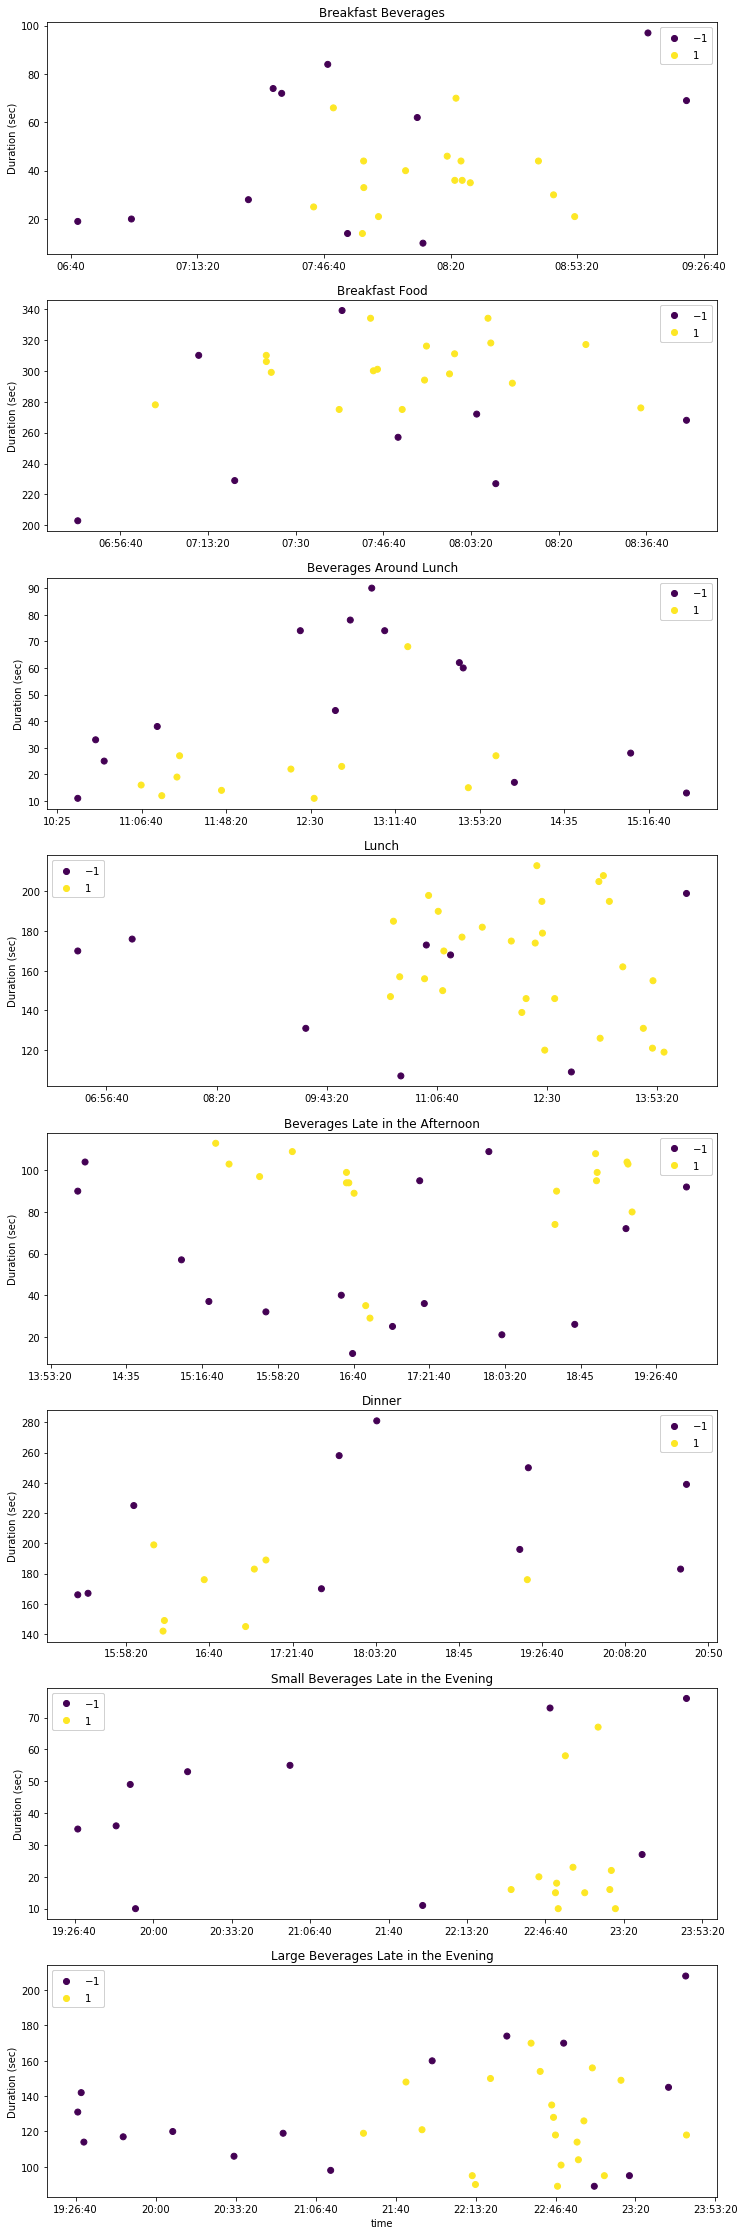

In [38]:
fig, ax = plt.subplots(figsize=(12,40),nrows=8,ncols=1)#create subplots with 8 rows and 1 column

#create a list of the dataframes we have defined for each routine
list_of_clusters_df = [break_bev_df,break_food_df,early_afternoon_bev_df,early_afternoon_food_df,late_afternoon_bev_df,
                       late_afternoon_food_df,late_evening_bev_small_df,late_evening_bev_large_df]

#create a list of the names of each dataframe we have defined for each routine
title_list = ['Breakfast Beverages','Breakfast Food','Beverages Around Lunch','Lunch','Beverages Late in the Afternoon','Dinner',
           'Small Beverages Late in the Evening','Large Beverages Late in the Evening']

for i,val in enumerate(list_of_clusters_df):#loop over the dataframes of each routine 
    
    #scatter plot: time vs duration, where we color the points with respect to if they are inliers or outliers
    scatter = ax[i].scatter(val.index.time,val['seconds'],c=val['Outliers']);
    
    ax[i].set_ylabel('Duration (sec)') #set y label
    ax[i].set_xlabel('') #delete all x labels
    
    #set legend
    legend1 = ax[i].legend(*scatter.legend_elements()) 
    ax[i].add_artist(legend1)
    
    #set title of each figure to the name of each different routine
    ax[i].set_title(title_list[i])

    
    
ax[-1].set_xlabel('time'); #add x label only to the last subplot

Hence, in the above figure we can notice that all the dark points are considered as anomalies of the corresponding routine by our algorithm. On the contrary, the yellow points are the inliers (normal points) of each routine. 

Finally, we concatenate all the dataframes of the different clusters into one. 

In [39]:
data_with_outliers = pd.concat([break_bev_df,break_food_df,early_afternoon_bev_df,early_afternoon_food_df,
                                late_afternoon_bev_df,late_afternoon_food_df,late_evening_bev_small_df,
                                late_evening_bev_large_df],axis=0)

Then we drop all the outliers and create a dataframe without them.

In [40]:
data_no_outliers = data_with_outliers.drop(data_with_outliers[data_with_outliers['Outliers'] == -1].index,axis=0)

We also make a scatter plot using the points of this new dataframe (hence using only the points identified as inliers).

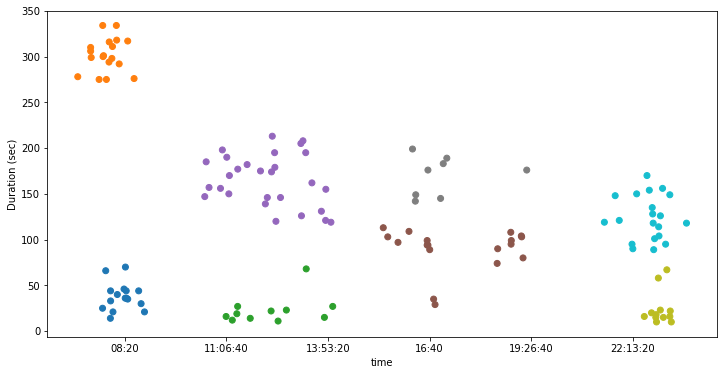

In [41]:
figure, ax = plt.subplots(figsize=(12,6))
ax.scatter(data_no_outliers.index.time,data_no_outliers['seconds'],c=data_no_outliers['Clusters'],cmap='tab10')
ax.set_ylabel('Duration (sec)');

From this figure, it becomes clear that now that we have identified and eliminated the outliers of the clusters we had defined earlier, the remaining points would be much more concetrated. 